# Results visualization

## Objective of the project 

This study seeks to conduct a thorough comparative analysis of these three models, focusing
on their performance with regards to accuracy, computational complexity, scalability, and their
effectiveness in handling data sparsity and dynamically changing environments. By evaluat-
ing these aspects, the research aims to illuminate the operational strengths and weaknesses
of each model, providing clear insights that could guide the development and deployment of
future recommender systems. Through this comparative framework, we aspire to answer which
model, under what conditions, provides the most reliable and robust recommendations, thereby
significantly contributing to the optimization of digital services.

In [13]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter, defaultdict
from surprise import Dataset, Reader, KNNBasic, SVD, CoClustering, accuracy
from sklearn.model_selection import train_test_split
from surprise.accuracy import rmse, mae

In [5]:
links_df = pd.read_csv('MovieLens_100k/links.csv')
movies_df = pd.read_csv('MovieLens_100k/movies.csv')
ratings_df = pd.read_csv('MovieLens_100k/ratings.csv')
tags_df = pd.read_csv('MovieLens_100k/tags.csv')

datasets = {
    "Links": links_df,
    "Movies": movies_df,
    "Ratings": ratings_df,
    "Tags": tags_df
}

datasets_info = {name: df.head() for name, df in datasets.items()}
datasets_info

{'Links':    movieId  imdbId   tmdbId
 0        1  114709    862.0
 1        2  113497   8844.0
 2        3  113228  15602.0
 3        4  114885  31357.0
 4        5  113041  11862.0,
 'Movies':    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  ,
 'Ratings':    userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  9

## Dataset structure

In [6]:
# Check for missing values in each dataset
missing_values = {name: df.isnull().sum() for name, df in datasets.items()}

# Print the information about missing values
for name, missing in missing_values.items():
    print(f"Missing values in {name} dataset:\n{missing}\n")

Missing values in Links dataset:
movieId    0
imdbId     0
tmdbId     8
dtype: int64

Missing values in Movies dataset:
movieId    0
title      0
genres     0
dtype: int64

Missing values in Ratings dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in Tags dataset:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64



In [7]:
# Print the shape of each DataFrame
for name, df in datasets.items():
    print(f"The shape of the {name} DataFrame is: {df.shape}")

The shape of the Links DataFrame is: (9742, 3)
The shape of the Movies DataFrame is: (9742, 3)
The shape of the Ratings DataFrame is: (100836, 4)
The shape of the Tags DataFrame is: (3683, 4)


In [8]:
distribution_of_ratings = ratings_df.groupby('rating').size().reset_index(name='count')
distribution_of_ratings

,rating,count
0,0.5,1370
1,1.0,2811
2,1.5,1791
3,2.0,7551
4,2.5,5550
5,3.0,20047
6,3.5,13136
7,4.0,26818
8,4.5,8551
9,5.0,13211


### Combined result for hypergraphs

This data is obtained from the notebooks for HyperGCN and Node2vec. Please check it for more information on how it was obtained. 

In [59]:
data_hypergcn = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["HyperGCN", "HyperGCN", "HyperGCN"],
    "MSE": [5.608074, 13.239963, 5.691181],
    "RMSE": [2.368137, 3.638676, 2.385620],
    "MAE": [2.050150, 3.480585, 2.063831],
    "Precision@10": [0.116924, 0.000000, 0.105558],
    "Recall@10": [0.009341, 0.000000, 0.008382],
    "Running Time (s)": [86.924503, 11.528216, 88.792880]
}

results_HyperGCN_combined = pd.DataFrame(data_hypergcn)

data_node2vec = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["Node2Vec", "Node2Vec", "Node2Vec"],
    "MSE": [47.267650, 48.482455, 47.357681],
    "RMSE": [6.875147, 6.962934, 6.881692],
    "MAE": [5.017519, 5.095941, 4.988233],
    "Precision@10": [0.473556, 0.407286, 0.442582],
    "Recall@10": [0.104442, 0.099925, 0.097093],
    "Running Time (s)": [57.877078, 38.807848, 59.448123]
}

results_Node2Vec_combined = pd.DataFrame(data_node2vec)

In [61]:
combined_results_final = pd.concat([results_HyperGCN_combined, results_Node2Vec_combined], ignore_index=True)
combined_results_final

,Scenario,Algorithm,MSE,RMSE,MAE,Precision@10,Recall@10,Running Time (s)
0,Normal,HyperGCN,5.608074,2.368137,2.050150,0.116924,0.009341,86.924503
1,Sparse,HyperGCN,13.239963,3.638676,3.480585,0.000000,0.000000,11.528216
2,New User,HyperGCN,5.691181,2.385620,2.063831,0.105558,0.008382,88.792880
3,Normal,Node2Vec,47.267650,6.875147,5.017519,0.473556,0.104442,57.877078
4,Sparse,Node2Vec,48.482455,6.962934,5.095941,0.407286,0.099925,38.807848
5,New User,Node2Vec,47.357681,6.881692,4.988233,0.442582,0.097093,59.448123


## RMSE visualization

In [73]:
# Creating the individual DataFrames with the provided data
data_node2vec = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["Node2Vec", "Node2Vec", "Node2Vec"],
    "MSE": [47.267650, 48.482455, 47.357681],
    "RMSE": [6.875147, 6.962934, 6.881692],
    "MAE": [5.017519, 5.095941, 4.988233],
    "Precision@10": [0.473556, 0.407286, 0.442582],
    "Recall@10": [0.104442, 0.099925, 0.097093],
    "Running Time (s)": [57.877078, 38.807848, 59.448123]
}

data_hypergcn = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["HyperGCN", "HyperGCN", "HyperGCN"],
    "MSE": [5.608074, 13.239963, 5.691181],
    "RMSE": [2.368137, 3.638676, 2.385620],
    "MAE": [2.050150, 3.480585, 2.063831],
    "Precision@10": [0.116924, 0.000000, 0.105558],
    "Recall@10": [0.009341, 0.000000, 0.008382],
    "Running Time (s)": [86.924503, 11.528216, 88.792880]
}

data_lightgcn = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["LightGCN", "LightGCN", "LightGCN"],
    "MSE": [1.300472, 1.353399, 1.352309],
    "RMSE": [1.140382, 1.163357, 1.162888],
    "MAE": [0.814420, 0.837602, 0.837188],
    "Precision@10": [0.749278, 0.750687, 0.751206],
    "Recall@10": [0.503184, 0.504528, 0.504964],
    "Running Time (s)": [16.588426, 2.137099, 0.539947]
}

data_gat = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["GAT", "GAT", "GAT"],
    "MSE": [5.279527, 9.903407, 8.366129],
    "RMSE": [2.297722, 3.146968, 2.892426],
    "MAE": [1.813445, 2.508598, 2.294709],
    "Precision@10": [0.640868, 0.665226, 0.656693],
    "Recall@10": [0.339237, 0.375002, 0.358051],
    "Running Time (s)": [76.762282, 9.373171, 2.174327]
}

data_graphsage = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["GraphSAGE", "GraphSAGE", "GraphSAGE"],
    "MSE": [0.995274, 1.191938, 2.352740],
    "RMSE": [0.997634, 1.091759, 1.533864],
    "MAE": [0.765923, 0.853637, 1.183540],
    "Precision@10": [0.737043, 0.729891, 0.732416],
    "Recall@10": [0.525224, 0.473050, 0.497194],
    "Running Time (s)": [71.149196, 8.101512, 1.240817]
}

# Creating the DataFrame with the provided data for SVD
data_svd = {
    "Scenario": ["Normal", "Sparse", "New User"],
    "Algorithm": ["SVD", "SVD", "SVD"],
    "RMSE": [0.882703, 0.946178, 0.882193],
    "MAE": [0.676092, 0.735762, 0.674224],
    "Precision@10": [0.746351, 0.718301, 0.745780],
    "Recall@10": [0.518142, 0.509393, 0.525009],
    "Running Time (s)": [1.232592, 0.324698, 1.197195]
}


# Creating DataFrames
df_svd = pd.DataFrame(data_svd)
df_lightgcn = pd.DataFrame(data_lightgcn)
df_gat = pd.DataFrame(data_gat)
df_graphsage = pd.DataFrame(data_graphsage)
df_hypergcn = pd.DataFrame(data_hypergcn)
df_node2vec = pd.DataFrame(data_node2vec)


# Combine all the DataFrames into one
final_combined_results = pd.concat([df_node2vec, df_hypergcn, df_lightgcn, df_gat, df_graphsage], ignore_index=True)
final_combined_results_svd = pd.concat([df_node2vec, df_hypergcn, df_lightgcn, df_gat, df_graphsage,df_svd], ignore_index=True)


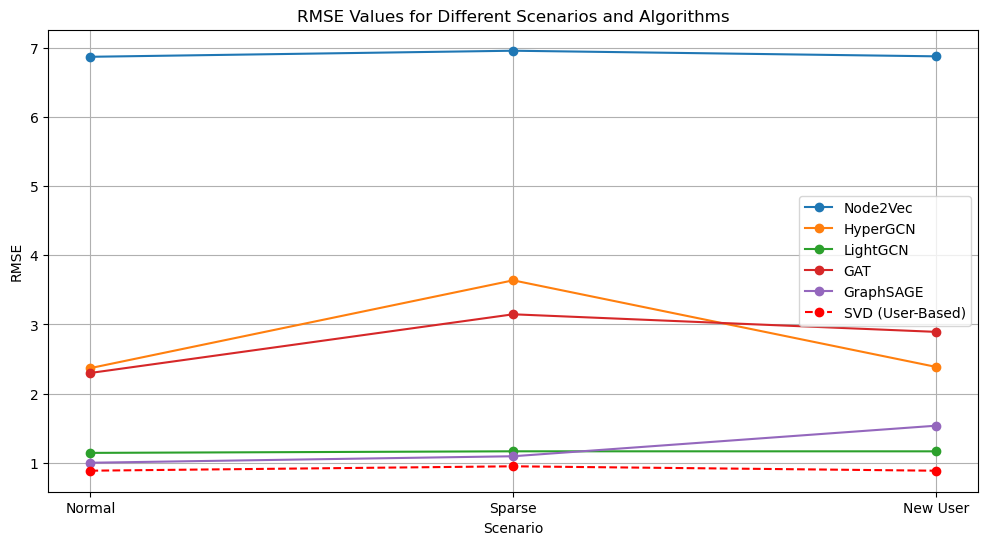

In [69]:
# Plotting the RMSE values for all scenarios and algorithms in the combined DataFrame
plt.figure(figsize=(12, 6))

for algorithm in final_combined_results['Algorithm'].unique():
    subset = final_combined_results[final_combined_results['Algorithm'] == algorithm]
    plt.plot(subset['Scenario'], subset['RMSE'], marker='o', label=algorithm)

# Plot the best algorithm (SVD User-Based)
plt.plot(df_svd['Scenario'], df_svd['RMSE'], marker='o', linestyle='--', color='red', label='SVD (User-Based)')

plt.xlabel('Scenario')
plt.ylabel('RMSE')
plt.title('RMSE Values for Different Scenarios and Algorithms')
plt.legend()
plt.grid(True)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1609: UserWarning: 
The markers list has

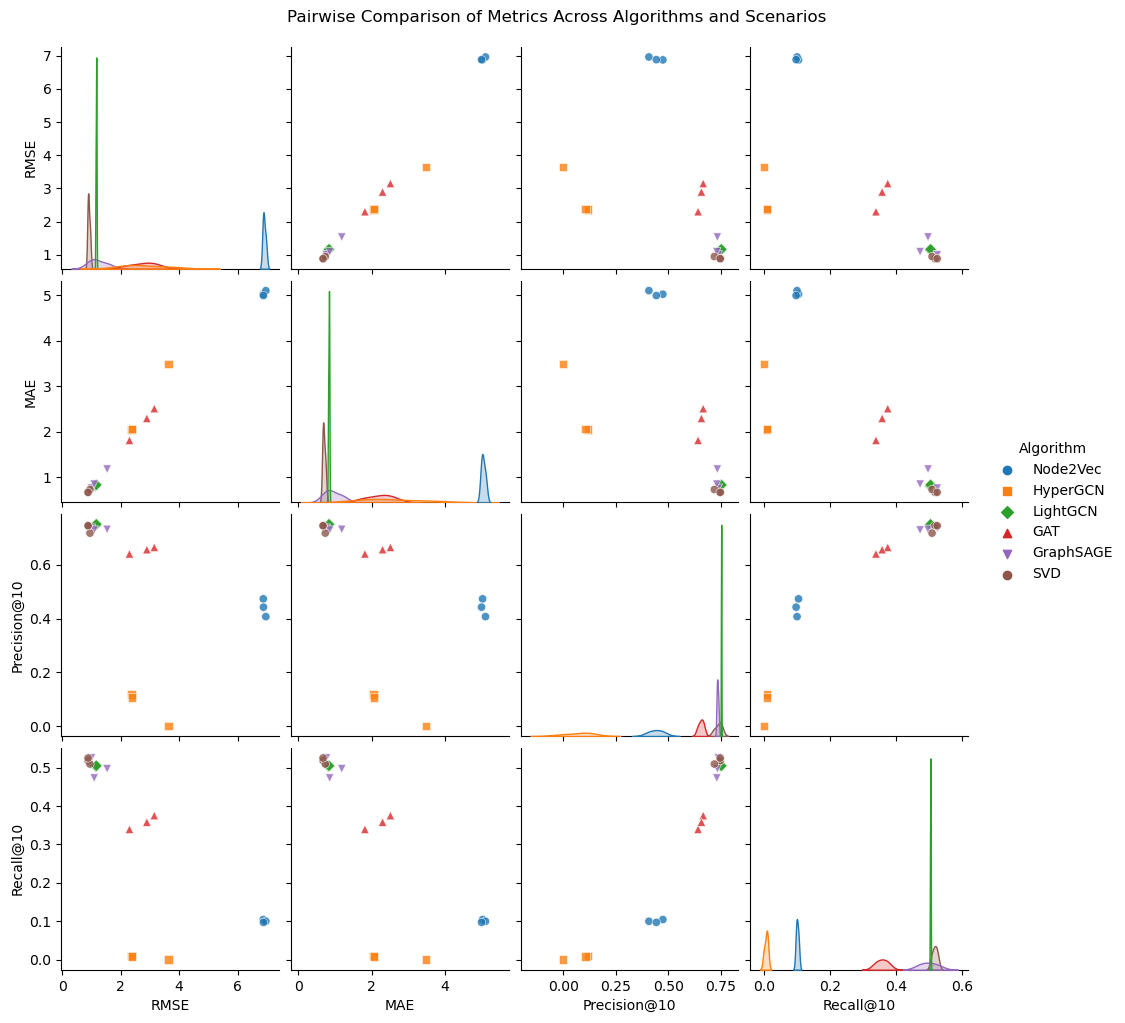

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting relevant columns for the pairplot
pairplot_df = final_combined_results_svd[["Algorithm", "Scenario", "RMSE", "MAE", "Precision@10", "Recall@10"]]

# Generating the pairplot
sns.pairplot(pairplot_df, hue="Algorithm", markers=["o", "s", "D", "^", "v"], plot_kws={'alpha':0.8})

plt.suptitle('Pairwise Comparison of Metrics Across Algorithms and Scenarios', y=1.02)
plt.show()